# Homework
## Preparing the data

In [87]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mutual_info_score, accuracy_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

In [88]:
df = pd.read_csv('https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv')

In [89]:
df.head()

,lead_source,industry,number_of_courses_viewed,annual_income,employment_status,location,interaction_count,lead_score,converted
0,paid_ads,NaN,1,79450.0,unemployed,south_america,4,0.94,1
1,social_media,retail,1,46992.0,employed,south_america,1,0.80,0
2,events,healthcare,5,78796.0,unemployed,australia,3,0.69,1
3,paid_ads,retail,2,83843.0,NaN,australia,1,0.87,0
4,referral,education,3,85012.0,self_employed,europe,3,0.62,1


In [90]:
df[['industry', 'lead_source', 'employment_status', 'location']] = df[['industry', 'lead_source', 'employment_status', 'location']].fillna('NA')
df[['annual_income']] = df[['annual_income']].fillna(0)

### Question 1
What is the most frequent observation (mode) for the column `industry`?

In [91]:
df.industry.mode()

0    retail
Name: industry, dtype: object

### Question 2
What are the two features that have the biggest correlation?

In [92]:
df.select_dtypes('number').corr()

,number_of_courses_viewed,annual_income,interaction_count,lead_score,converted
number_of_courses_viewed,1.000000,0.009770,-0.023565,-0.004879,0.435914
annual_income,0.009770,1.000000,0.027036,0.015610,0.053131
interaction_count,-0.023565,0.027036,1.000000,0.009888,0.374573
lead_score,-0.004879,0.015610,0.009888,1.000000,0.193673
converted,0.435914,0.053131,0.374573,0.193673,1.000000


- interaction_count and lead_score: 0.009888
- number_of_courses_viewed and lead_score: -0.004879
- number_of_courses_viewed and interaction_count: -0.023565
- annual_income and interaction_count: 0.027036

## Splitting the dataset

In [93]:
def data_split(df, test_size, val_size, random_state=42):
	df, df_test = train_test_split(df, test_size=test_size, random_state=random_state)
	df_train, df_val = train_test_split(df, test_size=val_size/(1-test_size), random_state=random_state)

	return df_train, df_val, df_test

In [94]:
df_train, df_val, df_test = data_split(df, test_size=.2, val_size=.2, random_state=42)

In [95]:
assert df_val.shape == df_test.shape

In [96]:
df_train.reset_index(drop=True, inplace=True)
df_val.reset_index(drop=True, inplace=True)
df_test.reset_index(drop=True, inplace=True)

## EDA
### Question 3
Which of these variables has the biggest mutual information score?

In [97]:
def mutual_info_churn_score(series):
	return mutual_info_score(series, df_train.converted)

In [98]:
categorical = ['lead_source', 'industry', 'employment_status', 'location']

In [99]:
df_mutual_info = df_train.select_dtypes(exclude='number').apply(mutual_info_churn_score)
df_mutual_info.sort_values(inplace=True)

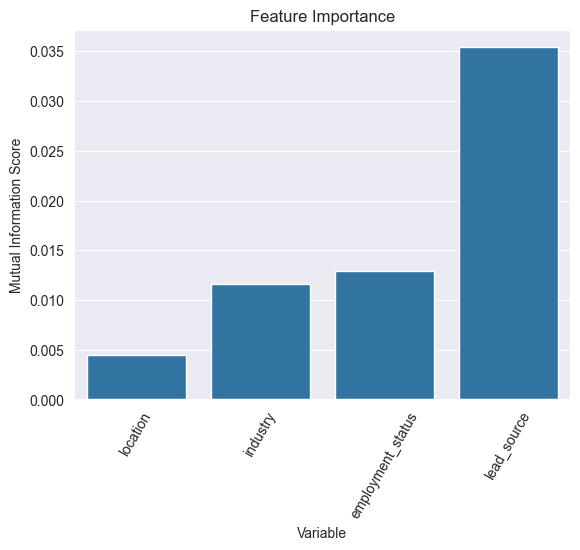

In [100]:
sns.barplot(x=df_mutual_info.index, y=df_mutual_info.values)
plt.xticks(rotation=60)
plt.title("Feature Importance")
plt.xlabel('Variable')
plt.ylabel('Mutual Information Score')
plt.show()

## Model training

In [101]:
y_train = df_train.converted.values
y_val = df_val.converted.values
y_test = df_test.converted.values

df_train.drop('converted', axis=1, inplace=True)
df_val.drop('converted', axis=1, inplace=True)
df_test.drop('converted', axis=1, inplace=True)

In [102]:
def one_hot_encoding(df, enc=None):
	# separate numerical and categorical features
	df_numerical = df.select_dtypes('number')
	df_categorical = df.select_dtypes(exclude='number')

	# fit a new encoder on the categorical data
	if not enc:
		enc = OneHotEncoder(dtype=np.int64, sparse_output=False)
		enc.fit(df_categorical)

	X = pd.DataFrame(
		data=enc.transform(df_categorical),
		columns=enc.get_feature_names_out())

	# combine encodings and numerical features
	df_encoded = pd.concat([df_numerical, X], axis=1)

	return df_encoded, enc

In [103]:
X_train, enc = one_hot_encoding(df_train)
X_val, _ = one_hot_encoding(df_val, enc)
X_test, _ = one_hot_encoding(df_test, enc)

In [104]:
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000, random_state=42)
model.fit(X_train.values, y_train)

LogisticRegression(max_iter=1000, random_state=42, solver='liblinear')

### Question 4
What is the validation accuracy of the model?

In [109]:
y_pred = model.predict(X_val.values)
full_model_accuracy = accuracy_score(y_pred, y_val)
full_model_accuracy

0.6996587030716723

### Feature selection

In [115]:
for col in ['industry', 'employment_status', 'lead_score']:
	df_train_subset = df_train.drop(col, axis=1)
	df_val_subset = df_val.drop(col, axis=1)

	X_train, enc = one_hot_encoding(df_train_subset)
	X_val, _ = one_hot_encoding(df_val_subset, enc)

	model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000, random_state=42)
	model.fit(X_train.values, y_train)

	y_pred = model.predict(X_val.values)
	model_accuracy = accuracy_score(y_pred, y_val)

	print("Variable removed from the training features: ", col)
	print("Performance impact: ", round(model_accuracy - full_model_accuracy, 4))

Variable removed from the training features:  industry
Performance impact:  0.0
Variable removed from the training features:  employment_status
Performance impact:  -0.0034
Variable removed from the training features:  lead_score
Performance impact:  0.0068


### Parameter tuning

In [119]:
X_train, enc = one_hot_encoding(df_train)
X_val, _ = one_hot_encoding(df_val, enc)
X_test, _ = one_hot_encoding(df_test, enc)

In [120]:
for C in [0.01, 0.1, 1, 10, 100]:
	model = LogisticRegression(solver='liblinear', C=C, max_iter=1000, random_state=42)
	model.fit(X_train.values, y_train)

	y_pred = model.predict(X_val.values)
	model_accuracy = accuracy_score(y_pred, y_val)

	print(f"C: {C} | Accuracy: {model_accuracy}")

C: 0.01 | Accuracy: 0.6996587030716723
C: 0.1 | Accuracy: 0.6996587030716723
C: 1 | Accuracy: 0.6996587030716723
C: 10 | Accuracy: 0.6996587030716723
C: 100 | Accuracy: 0.6996587030716723
